### Check if UMAP dimentionality reduction is Equally good for downstream task

In [35]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [36]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [37]:
rnaseq_df.head(5)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.678296,0.289910,0.034230,0.0,0.000000,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
1,0.200633,0.654917,0.181993,0.0,0.000000,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560
2,0.785980,0.140842,0.081082,0.0,0.000000,0.000000,0.000000,0.000000,0.730648,0.657189,...,0.437658,0.471489,0.868774,0.471141,0.487212,0.385521,0.466642,0.784059,0.160797,0.557074
3,0.720258,0.122554,0.180042,0.0,0.000000,0.000000,0.000000,0.000000,0.720306,0.719855,...,0.553306,0.373344,0.818608,0.691962,0.635023,0.430647,0.453690,0.364494,0.161363,0.607895
4,0.767127,0.210393,0.034017,0.0,0.061161,0.000000,0.053021,0.000000,0.739546,0.665684,...,0.601268,0.379943,0.506839,0.684320,0.607821,0.320113,0.476190,0.122722,0.389544,0.698548


In [38]:
import pandas as pd
import umap.umap_ as umap

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP(metric="manhattan").fit_transform(rnaseq_df)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([rnaseq_df, umap_df], axis=1)

In [39]:
embedded_dataframe = result_df.copy()

In [40]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [41]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [42]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [43]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [44]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

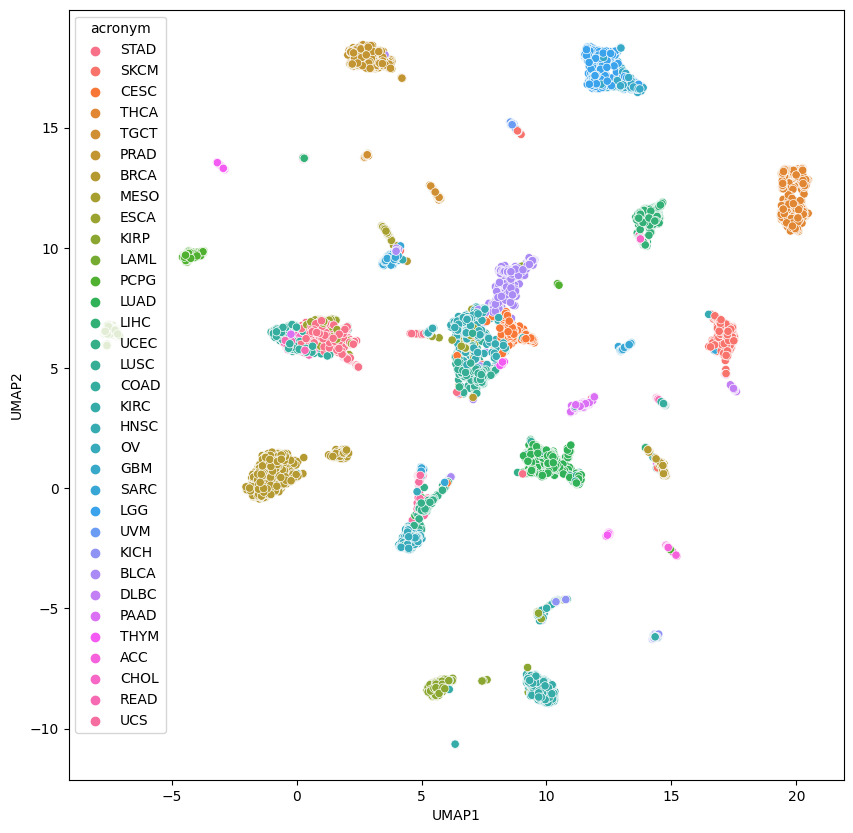

In [45]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")

In [56]:
def generate_2d_umap(metric):
    # Perform UMAP dimensionality reduction
    umap_result = umap.UMAP(metric="correlation").fit_transform(rnaseq_df)

    # Create a new DataFrame with UMAP coordinates
    umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

    # Concatenate the UMAP DataFrame with the original DataFrame
    result_df = pd.concat([rnaseq_df, umap_df], axis=1)

    embedded_dataframe = result_df.copy()

    tcga_tybalt_file_location = (
        "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
    )
    df = pd.read_table(tcga_tybalt_file_location)
    embedded_dataframe["id"] = df["Unnamed: 0"]

    # clinical data
    clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
    clincal_df = pd.read_table(clincal_file)

    clincal_df["id"] = clincal_df.portion_id.str[
        : embedded_dataframe["id"].str.len().min()
    ]
    merged_latent_clinical_df = pd.merge(
        clincal_df, embedded_dataframe, on="id", how="inner"
    )
    plt.figure(figsize=(10, 10))
    plt.title(metric)
    sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")

In [57]:
metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "cosine",
    "correlation",
    "hamming",
    "jaccard",
    "canberra",
    "braycurtis",
]

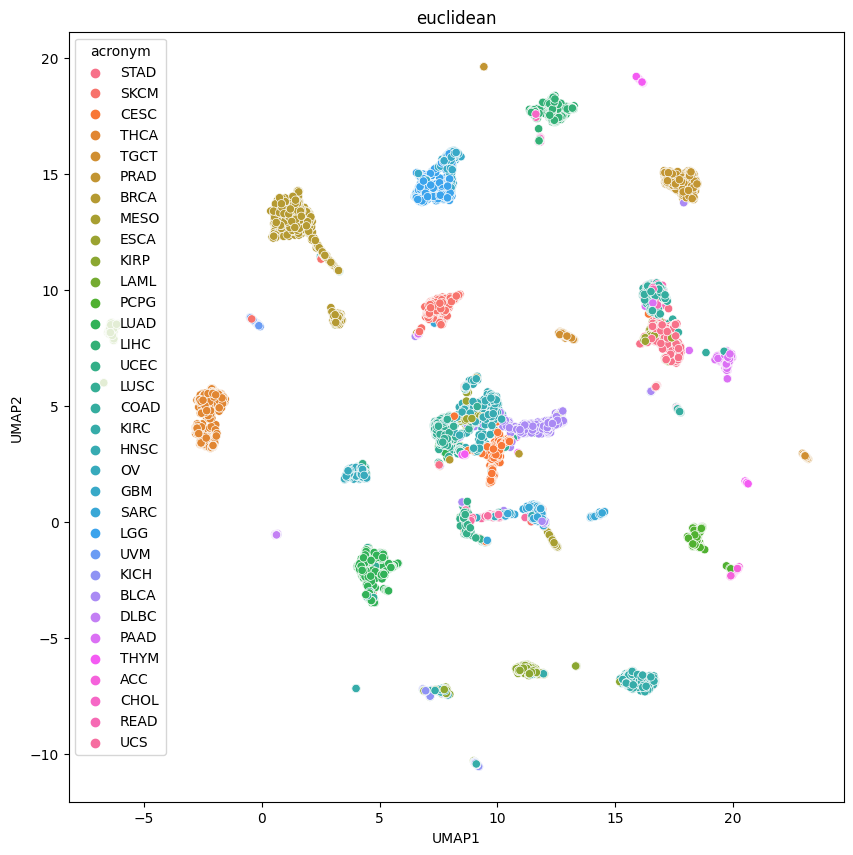

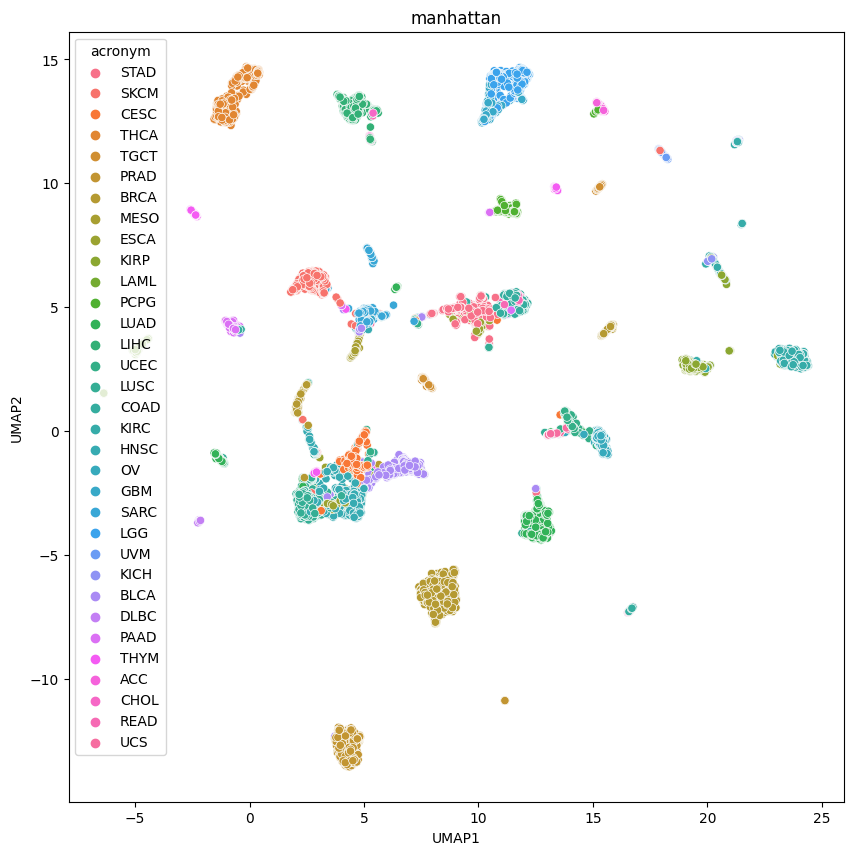

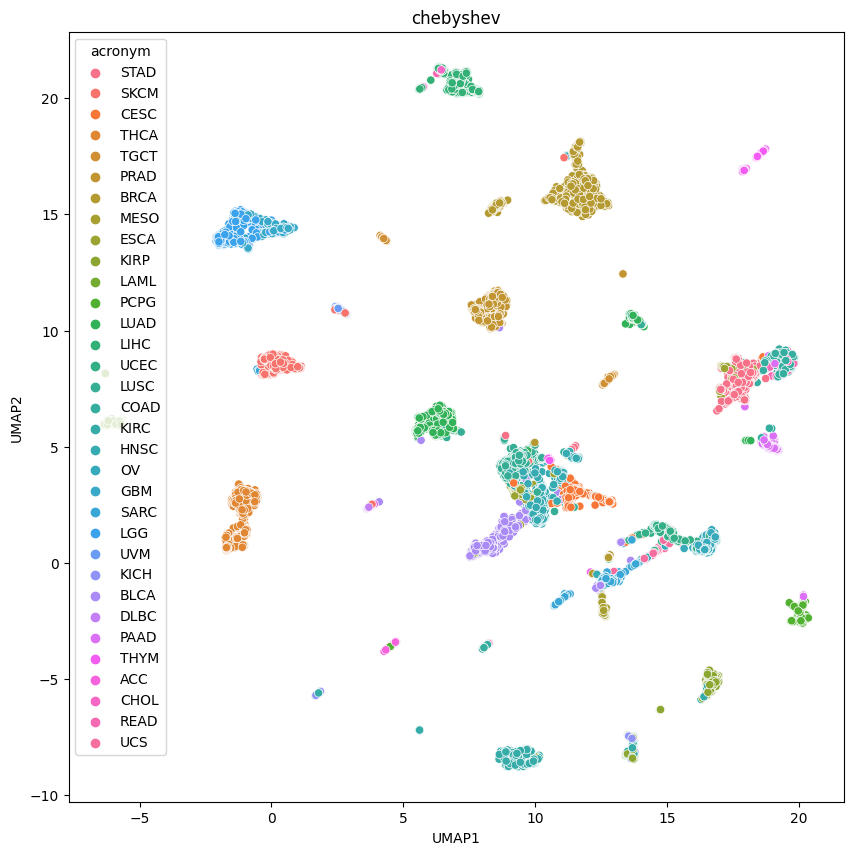

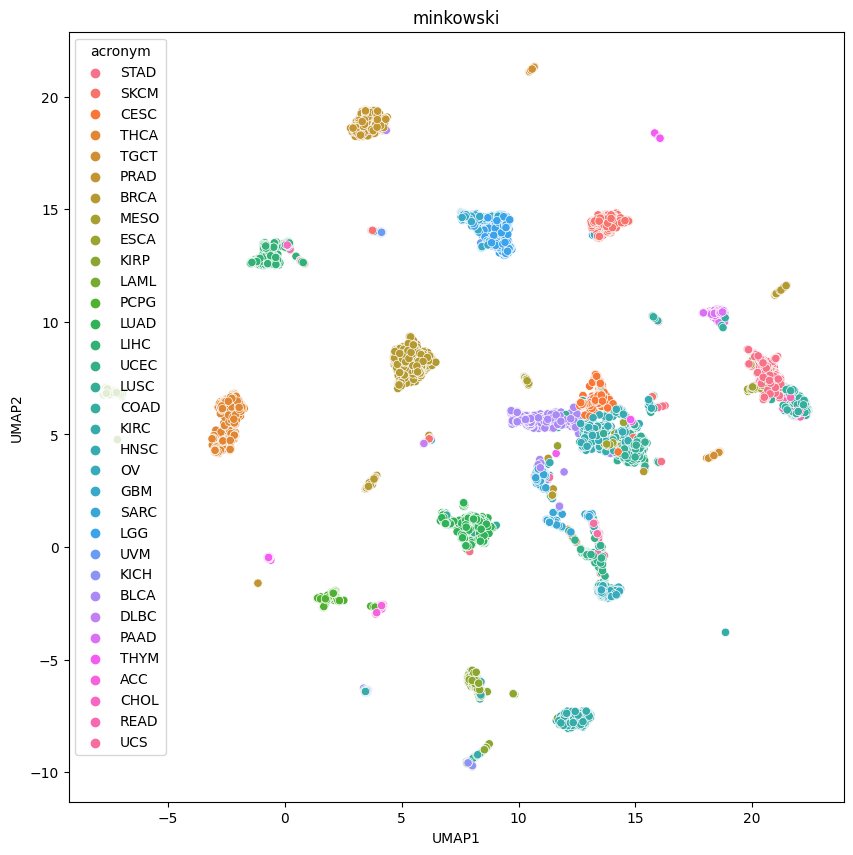

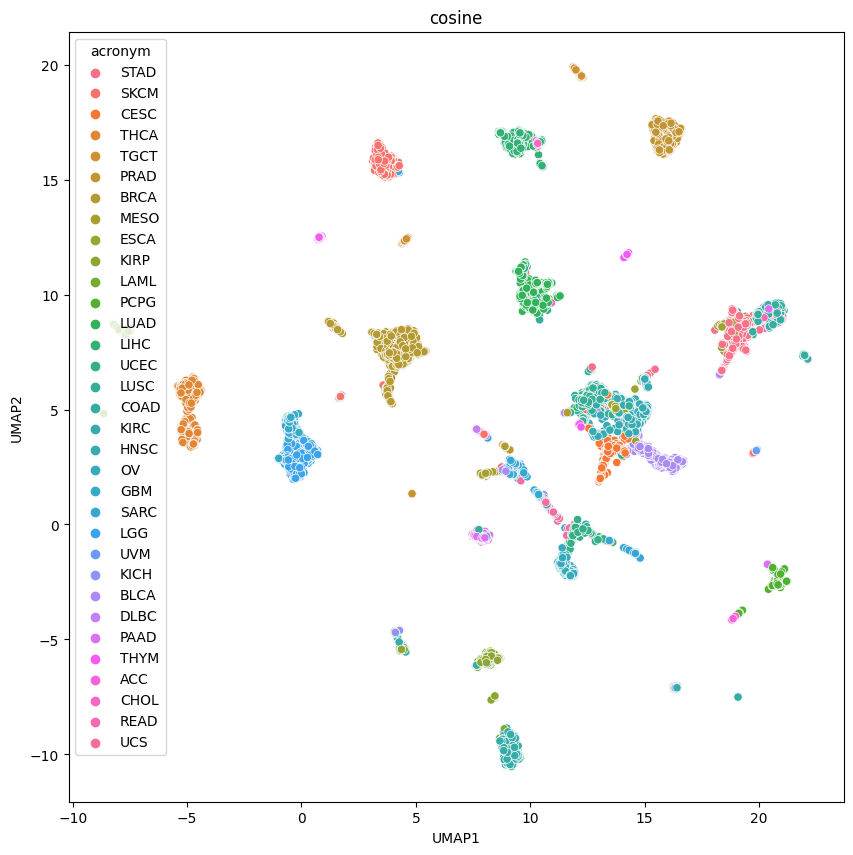

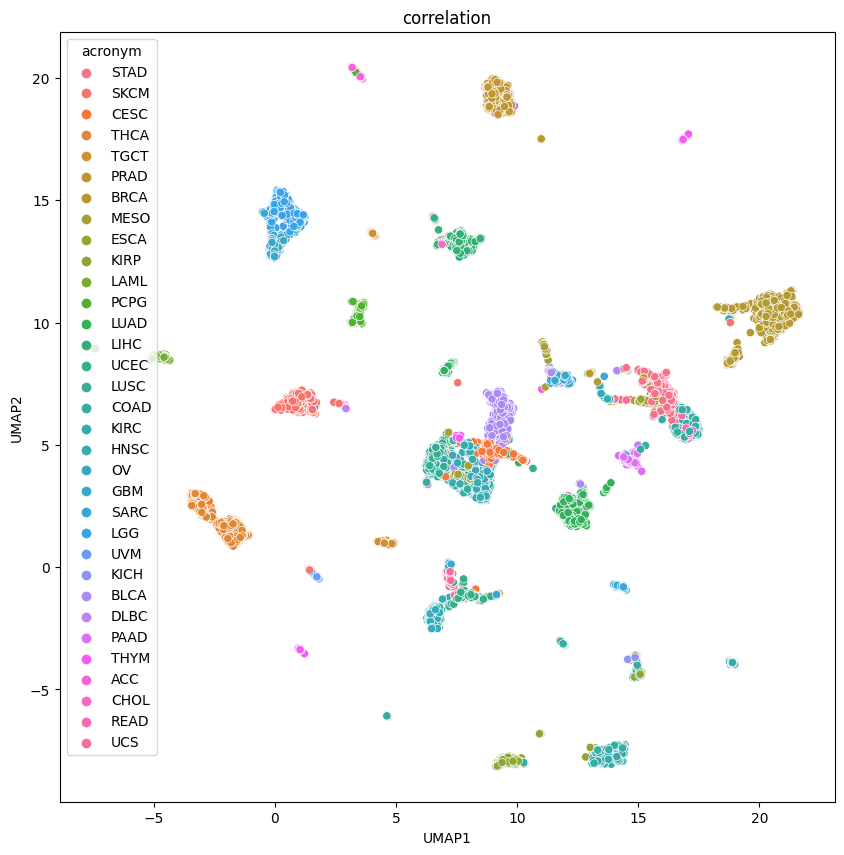

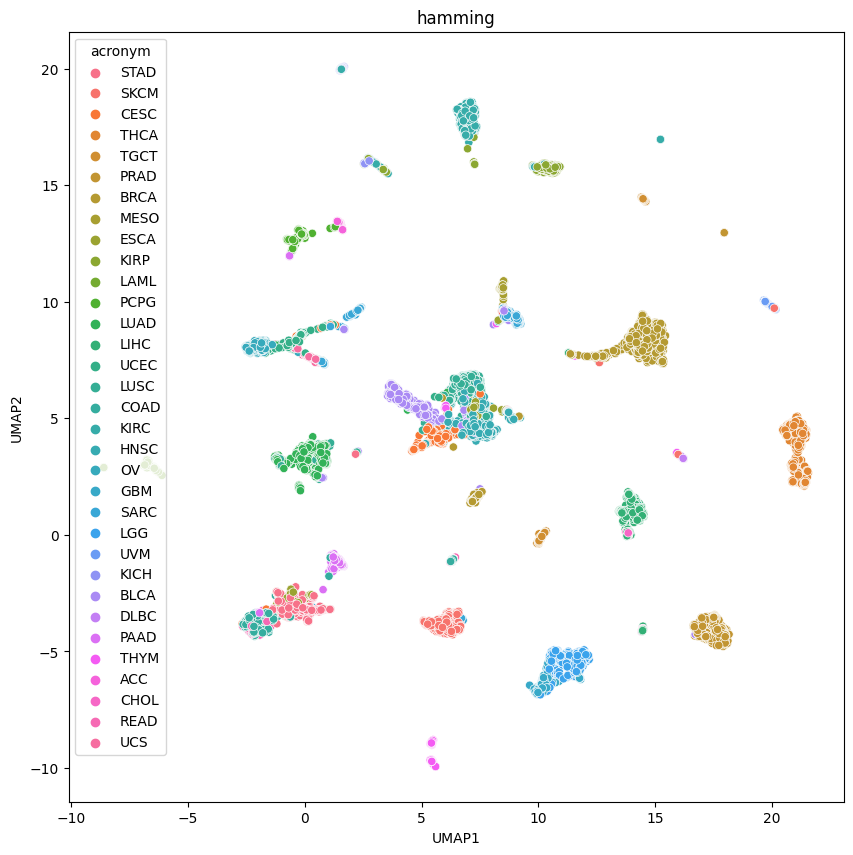

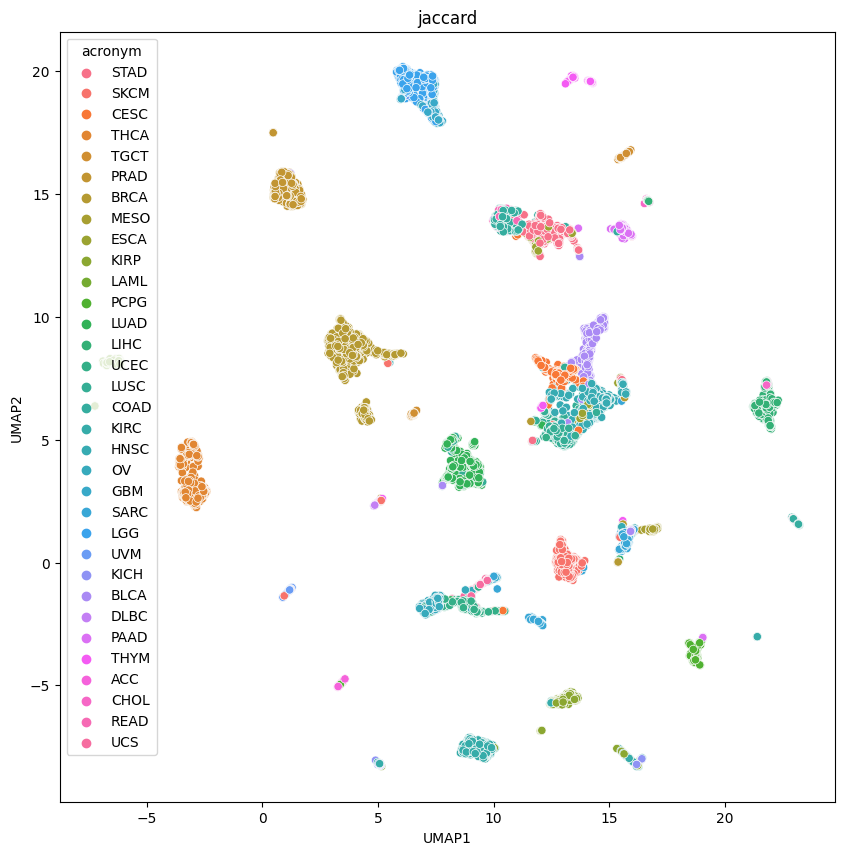

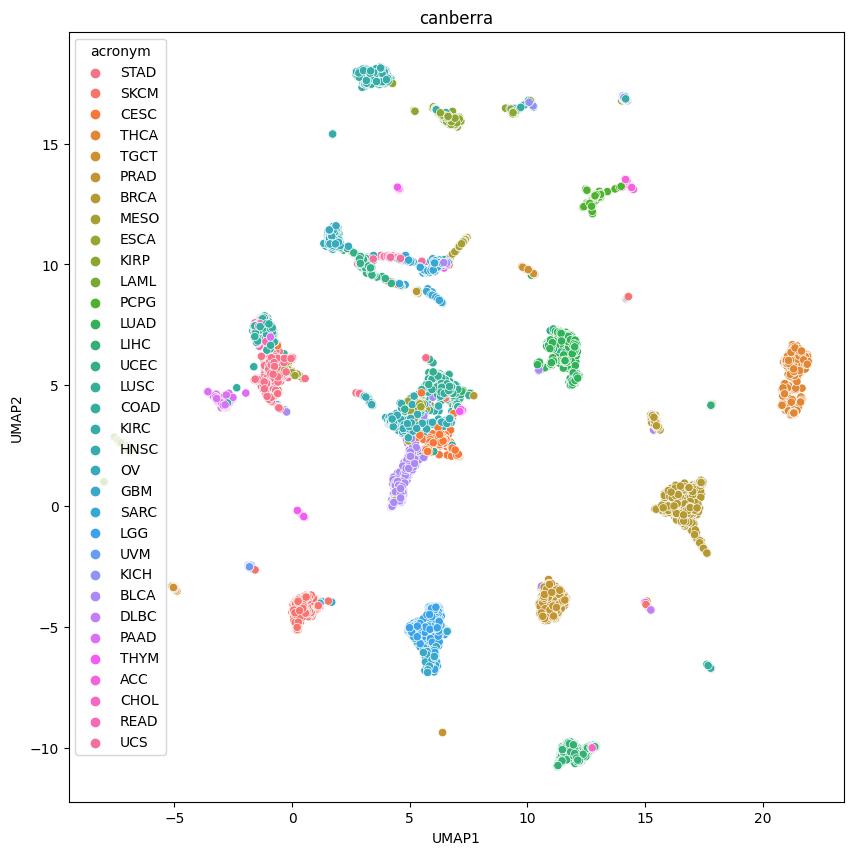

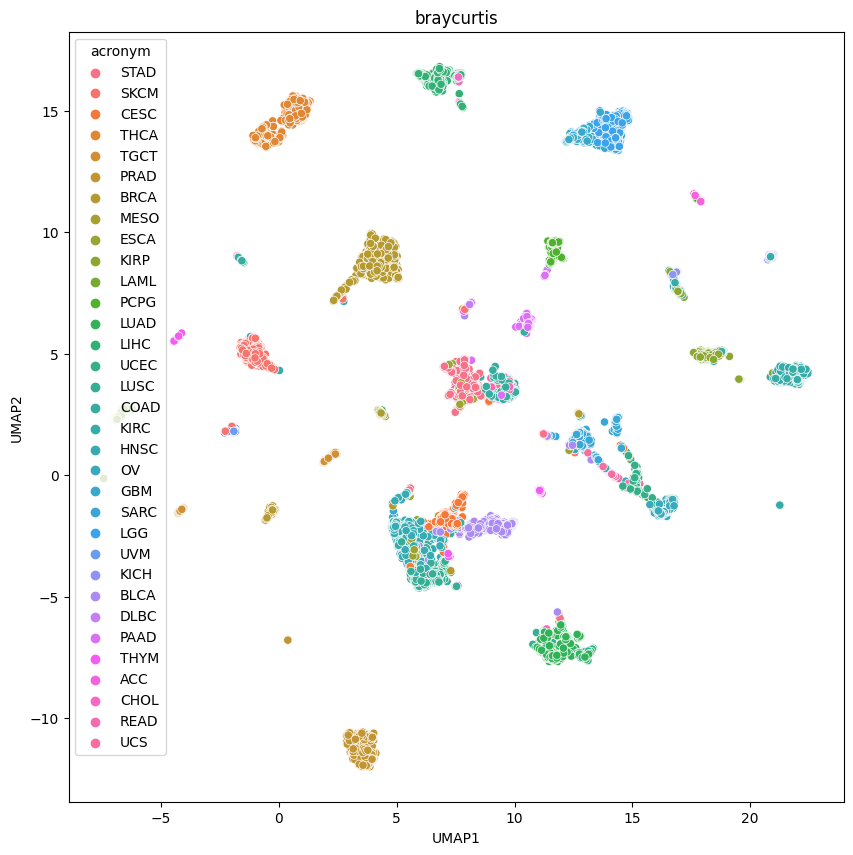

In [59]:
for i in metrics:
    generate_2d_umap(i)

In [22]:
arcronym_dict = {
    i: list(set(merged_latent_clinical_df["acronym"]))[i] for i in range(15)
}
acronyms = list(arcronym_dict.values())
elements_to_remove = ["BRCA", "KICH", "READ", "KIRP"]
new_list = [x for x in acronyms if x not in elements_to_remove]

In [23]:
def drop_rows_less_than_n_identical(df, column, n):
    # Count the number of identical values in the specified column
    counts = df[column].value_counts()

    # Get the values that have less than n occurrences
    values_to_drop = counts[counts < n].index.tolist()

    # Drop rows that have values less than n occurrences
    df = df[~df[column].isin(values_to_drop)]

    return df

In [28]:
# define a function which gives results for multiclass classification
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split


def cancer_classification(df):
    # Extract the features from the DataFrame
    features = df.iloc[:, 0:-1].values

    # Perform UMAP dimensionality reduction
    umap_result = umap.UMAP().fit_transform(features)

    # Create a new DataFrame with UMAP coordinates
    umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

    # Concatenate the UMAP DataFrame with the original DataFrame
    result_df = pd.concat([df, umap_df], axis=1)
    embedded_dataframe = result_df.copy()
    embedded_dataframe["id"] = df_tcga_tybalt["Unnamed: 0"]

    merged_latent_clinical_df = pd.merge(
        clincal_df, embedded_dataframe, on="id", how="inner"
    )

    # Split the DataFrame into features (X) and labels (y)
    merged_l_df = merged_latent_clinical_df.copy()
    merged_l_df = merged_l_df.dropna()

    column_name = "acronym"
    n = 2

    merged_l_df = drop_rows_less_than_n_identical(merged_l_df, column_name, n)

    merged_l_df = merged_l_df[merged_l_df["acronym"].isin(new_list)]

    merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

    X = merged_l_df[["UMAP1", "UMAP2"]]
    y = merged_l_df["acronym"]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize and train the classifier
    QDA = QuadraticDiscriminantAnalysis()
    classifier = QDA
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Compute roc_auc_score
    auc_roc = roc_auc_score(
        pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro"
    )

    # Compute F1-score
    f1 = f1_score(y_test, y_pred, average="macro")

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute classification report
    classification_metrics = classification_report(y_test, y_pred)

    # Print the AUC-ROC, F1-score, accuracy, and classification report
    # print("AUC-ROC:", auc_roc)
    # print("F1-score:", f1)
    # print("Accuracy:", accuracy)
    # print("Classification Report:\n", classification_metrics)

    return f1, auc_roc, accuracy, classification_metrics

In [29]:
cancer_classif = cancer_classification(rnaseq_df)

In [33]:
print("Classification Report:\n", cancer_classif[3])

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.93      1.00      0.97        28
           2       0.91      0.91      0.91        22
           3       1.00      0.95      0.98        22
           4       0.97      0.94      0.95        33
           5       1.00      1.00      1.00         9

    accuracy                           0.96       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.96      0.96      0.96       122



In [ ]:
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2

# Load sample dataset (Iris)
iris = load_iris()
X = iris.data
y = iris.target

# Feature selection
k = 2  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

# Fit QDA on selected features
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_new, y)

# Print selected feature indices
mask = selector.get_support(indices=True)
print("Selected feature indices:")
print(mask)

# Print selected feature names
feature_names = iris.feature_names
selected_features = [feature_names[i] for i in mask]
print("Selected features:")
print(selected_features)